# Importando as bibliotecas

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sn
import os
import sys
sys.path.insert(0, os.path.abspath('../Util'))
from dados import ProcessarDados

In [90]:
# Dataset

In [91]:
procData = ProcessarDados("../dataset/norm_bin_10_FEATURES_M17_CM6b_TH199.csv")

In [92]:
# Funções

In [93]:
# funcção que treina e testa o modelo armazenando as métricas
# retorna um dicionário cotendo os valores das métricas de cada rodada
def treinamento_teste(epocas = 10, k_folds = 5, exibir_matriz_confusao=False, exibir_metricas=False):
    
    #array para armazenar as das métricas de cada rodada
    resultados_accuracy = []
    resultados_precision = []
    resultados_recall = []
    resultados_f1 = []
    resultados_parametros = []
    resultados_matriz = []

    
    #dicionário das métricas
    resultados_gerais = {}

    for i in range(epocas):
        # divisão os dados 
        seed = i
        X_train, X_test, y_train, y_test = procData.holdout(0.2, seed)
        #print(Counter(y_test))

        # realizando o grid search para encontrar a melhor K-Vizinhos, 
        # considerando a acurácia (taxa de acerto)
        # aqui o método GridSearchCV é configurado para subdividir os dados de treino em k_folds
        clf = KNeighborsClassifier()
        grid_knn = GridSearchCV(clf, param_grid, cv=k_folds, scoring='accuracy', verbose=0)
        grid_knn.fit(X_train, y_train)
        
        # Treinando do modelo com os melhores parametros encontrados
        grid_knn.best_params_
        Kvizinhos_best = int(grid_knn.best_params_['n_neighbors']) 
        pesos_best = int(grid_knn.best_params_['p'])
        KNN = KNeighborsClassifier(n_neighbors=Kvizinhos_best, metric='minkowski', p = pesos_best)
        KNN.fit(X_train, y_train)

        #testando o modelo
        y_pred = KNN.predict(X_test)
        if exibir_matriz_confusao:
            print(confusion_matrix(y_test, y_pred))

        # calculado as metricas
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        matriz = metrics.confusion_matrix(y_test, y_pred)
        
        f1_score = 2 * (precision * recall) / (precision + recall)

        # armazenando as métricas
        resultados_accuracy.append(accuracy)
        resultados_precision.append(precision)
        resultados_recall.append(recall)
        resultados_f1.append(f1_score)
        resultados_matriz.append(matriz)

        #best_parametros = "K-Vizinhos (n_neighbors): "+ str(Kvizinhos_best)+ " | Peso (p): "+str(pesos_best);
        best_parametros = {'n_neighbors': Kvizinhos_best, 'p': pesos_best};
        resultados_parametros.append(best_parametros)



        if exibir_metricas:
            print("Rodada:",i)
            print("Parâmetros:",best_parametros)
            print("Accuracy:",accuracy)
            print("Precision:",precision)
            print("Recall:",recall)
            print("F1-Score:",f1_score)
            print("\n")

            
    resultados_gerais['accuracy'] = resultados_accuracy
    resultados_gerais['precision'] = resultados_precision
    resultados_gerais['recall'] = resultados_recall
    resultados_gerais['f1'] = resultados_f1
    resultados_gerais['params'] = resultados_parametros
    resultados_gerais['matriz'] = resultados_matriz
    
    return resultados_gerais

In [94]:
def tabelaMetricas(nome_modelo, dict_metricas, rodadas=False, salvarResultados=True):
    print ("============================================== "+nome_modelo+" =================================================")
    print ("=================================== RESULTADOS DAS MÉTRICAS DO MODELO ==============================")
    
    if(rodadas==False):
        print ("\t Accuracy \t|\t Precision \t|\t Recall \t|\t F1-Score")
        print ("      %.2f +- %.2f" % (np.mean(dict_metricas['accuracy'], axis=0), np.std(dict_metricas['accuracy'], axis=0)),end='       ')
        print ("      %.2f +- %.2f" % (np.mean(dict_metricas['precision'], axis=0), np.std(dict_metricas['precision'], axis=0)),end='    ')
        print ("      %.2f +- %.2f" % (np.mean(dict_metricas['recall'], axis=0), np.std(dict_metricas['recall'], axis=0)),end='       ')
        print ("      %.2f +- %.2f" % (np.mean(dict_metricas['f1'], axis=0), np.std(dict_metricas['f1'], axis=0)))

        print ("")
        print ("=================================== MELHORES RESULTADOS ============================================")

        indice_accuracy = np.array(dict_metricas['accuracy'])
        melhor_accuracy = indice_accuracy.flatten()[np.argmax(indice_accuracy)] #retorna o maior valor
        melhor_params_accuracy = dict_metricas['params'][np.argmax(indice_accuracy)]
        melhor_matriz_accuracy = dict_metricas['matriz'][np.argmax(indice_accuracy)]
        
        indice_precision = np.array(dict_metricas['precision'])
        melhor_precision = indice_precision.flatten()[np.argmax(indice_precision)] #retorna o maior valor
        melhor_params_precision = dict_metricas['params'][np.argmax(indice_precision)]
        melhor_matriz_precision = dict_metricas['matriz'][np.argmax(indice_precision)]
        
        indice_recall = np.array(dict_metricas['recall'])
        melhor_recall = indice_recall.flatten()[np.argmax(indice_recall)] #retorna o maior valor
        melhor_params_recall = dict_metricas['params'][np.argmax(indice_recall)]
        melhor_matriz_recall = dict_metricas['matriz'][np.argmax(indice_recall)]
        
        indice_f1 = np.array(dict_metricas['f1'])
        melhor_f1 = indice_f1.flatten()[np.argmax(indice_f1)] #retorna o maior valor
        melhor_params_f1 = dict_metricas['params'][np.argmax(indice_f1)]        
        melhor_matriz_f1 = dict_metricas['matriz'][np.argmax(indice_f1)]
        
        print ("Accuracy")
        print ("Rodada:", np.argmax(indice_accuracy)," | Parâmetro:", melhor_params_accuracy, " | Resultado:",melhor_accuracy)
        print ("Matriz de Confusão:")
        print (melhor_matriz_accuracy)
        sn.heatmap(melhor_matriz_accuracy, annot=True)
        plt.show()
        
        print ("")
        print ("Precision")
        print ("Rodada:", np.argmax(indice_precision)," | Parâmetro:", melhor_params_precision, " | Resultado:",melhor_precision)
        print ("Matriz de Confusão:")
        print (melhor_matriz_precision)
        sn.heatmap(melhor_matriz_precision, annot=True)
        plt.show()

        print ("")
        print ("Recall:")
        print ("Rodada:", np.argmax(indice_recall)," | Parâmetro:", melhor_params_recall, " | Resultado:",melhor_recall)
        print ("Matriz de Confusão:")
        print (melhor_matriz_recall)
        print ("")
        sn.heatmap(melhor_matriz_recall, annot=True)
        plt.show()
        
        print ("F1-Score:")
        print ("Rodada:", np.argmax(indice_f1)," | Parâmetro:", melhor_params_f1, " | Resultado:",melhor_f1)
        print ("Matriz de Confusão:")
        print (melhor_matriz_f1)        
        sn.heatmap(melhor_matriz_f1, annot=True)
        plt.show()

        print ("===================================================================================================")
        
    if(salvarResultados):
        # save to npy file
        np.save('../resultados/resultados_'+nome_modelo+'.npy', dict_metricas)

# Definindo os parâmetros

In [95]:
k_range = np.arange(1,25,1) # K-Vizinhos a serem testados no SearchGridCV 
pesos = [1, 2] # 1:Manhattan | 2:Euclidiana
param_grid = {'n_neighbors': k_range, 'p': pesos}
epocas = 10
k_folds = 5
exibir_matriz_confusao = True
exibir_metricas = True

# Treinando e obtendo as métricas do modelo

C:\Users\Eduardo Valente\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[23  5]
 [ 8 84]]
Rodada: 0
Parâmetros: {'n_neighbors': 1, 'p': 1}
Accuracy: 0.8916666666666667
Precision: 0.9438202247191011
Recall: 0.9130434782608695
F1-Score: 0.9281767955801105


[[20 13]
 [ 5 82]]
Rodada: 1
Parâmetros: {'n_neighbors': 1, 'p': 2}
Accuracy: 0.85
Precision: 0.8631578947368421
Recall: 0.9425287356321839
F1-Score: 0.901098901098901


[[13  9]
 [ 7 91]]
Rodada: 2
Parâmetros: {'n_neighbors': 7, 'p': 1}
Accuracy: 0.8666666666666667
Precision: 0.91
Recall: 0.9285714285714286
F1-Score: 0.9191919191919193




C:\Users\Eduardo Valente\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[25  7]
 [ 2 86]]
Rodada: 3
Parâmetros: {'n_neighbors': 3, 'p': 2}
Accuracy: 0.925
Precision: 0.9247311827956989
Recall: 0.9772727272727273
F1-Score: 0.9502762430939227




C:\Users\Eduardo Valente\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[25  3]
 [ 5 87]]
Rodada: 4
Parâmetros: {'n_neighbors': 1, 'p': 2}
Accuracy: 0.9333333333333333
Precision: 0.9666666666666667
Recall: 0.9456521739130435
F1-Score: 0.956043956043956




C:\Users\Eduardo Valente\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[19 13]
 [ 5 83]]
Rodada: 5
Parâmetros: {'n_neighbors': 1, 'p': 2}
Accuracy: 0.85
Precision: 0.8645833333333334
Recall: 0.9431818181818182
F1-Score: 0.9021739130434783




C:\Users\Eduardo Valente\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[16  6]
 [ 6 92]]
Rodada: 6
Parâmetros: {'n_neighbors': 1, 'p': 2}
Accuracy: 0.9
Precision: 0.9387755102040817
Recall: 0.9387755102040817
F1-Score: 0.9387755102040817




C:\Users\Eduardo Valente\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[23  8]
 [ 3 86]]
Rodada: 7
Parâmetros: {'n_neighbors': 5, 'p': 1}
Accuracy: 0.9083333333333333
Precision: 0.9148936170212766
Recall: 0.9662921348314607
F1-Score: 0.9398907103825136


[[20  7]
 [ 2 91]]
Rodada: 8
Parâmetros: {'n_neighbors': 3, 'p': 1}
Accuracy: 0.925
Precision: 0.9285714285714286
Recall: 0.978494623655914
F1-Score: 0.9528795811518325


[[23  6]
 [ 3 88]]
Rodada: 9
Parâmetros: {'n_neighbors': 7, 'p': 1}
Accuracy: 0.925
Precision: 0.9361702127659575
Recall: 0.967032967032967
F1-Score: 0.9513513513513513


============================================== KNN =================================================
=================================== RESULTADOS DAS MÉTRICAS DO MODELO ==============================
	 Accuracy 	|	 Precision 	|	 Recall 	|	 F1-Score
      0.90 +- 0.03             0.92 +- 0.03          0.95 +- 0.02             0.93 +- 0.02

=================================== MELHORES RESULTADOS ============================================
Accuracy
Rodada: 4  | Parâmet

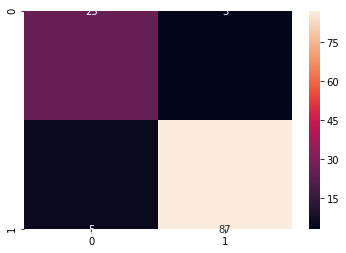


Precision
Rodada: 4  | Parâmetro: {'n_neighbors': 1, 'p': 2}  | Resultado: 0.9666666666666667
Matriz de Confusão:
[[25  3]
 [ 5 87]]


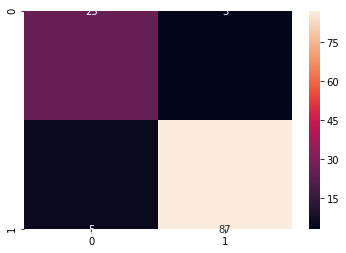


Recall:
Rodada: 8  | Parâmetro: {'n_neighbors': 3, 'p': 1}  | Resultado: 0.978494623655914
Matriz de Confusão:
[[20  7]
 [ 2 91]]



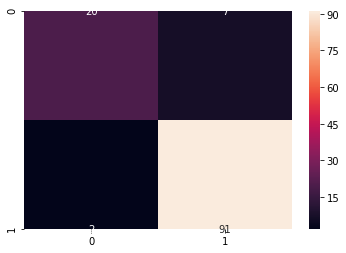

F1-Score:
Rodada: 4  | Parâmetro: {'n_neighbors': 1, 'p': 2}  | Resultado: 0.956043956043956
Matriz de Confusão:
[[25  3]
 [ 5 87]]


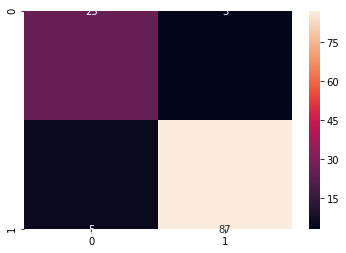

In [96]:
# treinando o modelo
dict_metricas = treinamento_teste(epocas, k_folds, exibir_matriz_confusao, exibir_metricas)
tabelaMetricas('KNN',dict_metricas)